<a href="https://colab.research.google.com/github/buffyhridoy/drug_discovery/blob/main/Drug_Discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing libraries

Install the ChEMBL web service package so that we can retrieve bioactivity data from the ChEMBL Database.

In [1]:
! pip install chembl_webresource_client


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 60 kB 9.3 MB/s 
  Attempting uninstall: itsdangerous
    Found existing installation: itsdangerous 1.1.0
    Uninstalling itsdangerous-1.1.0:
      Successfully uninstalled itsdangerous-1.1.0
  Attempting uninstall: attrs
    Found existing installation: attrs 22.1.0
    Uninstalling attrs-22.1.0:
      Successfully uninstalled attrs-22.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires itsdangerous<2.0,>=0.24, but you have itsdangerous 2.1.2 which is incompatible.


In [2]:
! pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 1.2 MB/s 


## Importing libraries

In [3]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem.MolStandardize import rdMolStandardize
from chembl_webresource_client.new_client import new_client
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt

## Search for Target ABL kinase protein

In [4]:
target = new_client.target
target_query = target.search('CHEMBL4895')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P30530', 'xref_name': None, 'xre...",Homo sapiens,Tyrosine-protein kinase receptor UFO,14.0,False,CHEMBL4895,"[{'accession': 'P30530', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Homo sapiens,TEL/AXL,10.0,False,CHEMBL4523666,"[{'accession': 'P30530', 'component_descriptio...",CHIMERIC PROTEIN,9606


### Select and retrieve bioactivity data for Tyrosine-ABL-kinase

In [5]:
selected_target = targets.target_chembl_id[0]
selected_target

'CHEMBL4895'

Here, we will retrieve only bioactivity data for *ABL kinase* (CHEMBL1862) that are reported as IC$_{50}$ values in nM (nanomolar) unit.

### Extracting IC50 data

In [6]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

### Converting data to dataframe

In [7]:
df = pd.DataFrame.from_dict(res)
df.head(3)

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1769379,[],CHEMBL910899,Inhibition of Axl kinase,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Tyrosine-protein kinase receptor UFO,9606,None,None,IC50,uM,UO_0000065,None,1.0
1,None,1790119,[],CHEMBL873747,Inhibition of Axl,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Tyrosine-protein kinase receptor UFO,9606,None,None,IC50,nM,UO_0000065,None,389.0
2,None,1790289,[],CHEMBL873747,Inhibition of Axl,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Tyrosine-protein kinase receptor UFO,9606,None,None,IC50,nM,UO_0000065,None,455.0


In [8]:
df.standard_type.unique()

array(['IC50'], dtype=object)

## Handling missing data
If any compounds has missing value for the **standard_value** column then drop it

In [9]:
df = df[df.standard_value.notna()]

Apparently, for this dataset there is no missing data. But we can use the above code cell for bioactivity data of other target protein.

## Data pre-processing of the bioactivity data

### Labeling compounds as either being active, inactive or intermediate
The bioactivity data is in the IC50 unit. Compounds having values of less than 1000 nM will be considered to be **active** while those greater than 10,000 nM will be considered to be **inactive**. As for those values in between 1,000 and 10,000 nM will be referred to as **intermediate**. 

In [10]:
df['standard_value'] = df['standard_value'].astype(float)
df['bioactivity_class'] = df['standard_value'].map(lambda x : 'active' if x <= 1000 else ('inactive' if x >=10000 else 'intermediate'))

In [11]:
selection = ['molecule_chembl_id', 'canonical_smiles', 'standard_value','bioactivity_class']
df = df[selection]
df.head(5)

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL215803,C[C@@H]1C[C@H]2CN1CCn1nc3c(cccc3c1O)-c1nc3c(cc...,1000.0,active
1,CHEMBL253116,CC(CO)NC(=N)c1c(O)nsc1Nc1ccc(Nc2ccccc2)cc1,389.0,active
2,CHEMBL437331,CC(CO)/N=C(\N)c1c(O)nsc1Nc1ccc(Oc2ccccc2)cc1,455.0,active
3,CHEMBL254702,CC1CCN(c2cc(N3CCN(C)CC3)ccc2NC(=O)c2cc(C#N)c[n...,6.4,active
4,CHEMBL253292,CCN(CC)CCOc1ccc(Nc2cc(NC(=O)Nc3c(Cl)cccc3Cl)nc...,10000.0,inactive


df.canonical_smiles.replace('nan',np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(inplace=True)

In [12]:
'''
function to estimate molecule Lipinski descriptors

'''

def lipinski(smiles, verbose=False):
    moldata= []
    problematic_smiles=[]
    for i,elem in enumerate(smiles):
        try:
            mol=Chem.MolFromSmiles(elem) 
            mol = rdMolStandardize.Cleanup(mol)
            moldata.append(mol)  
        except:
            problematic_smiles.append(i)
            pass
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return  descriptors,problematic_smiles

In [13]:
df_lipinski, problematic_smiles = lipinski(df.canonical_smiles)

In [14]:
df_lipinski.head(10).style.background_gradient()

,MW,LogP,NumHDonors,NumHAcceptors
0,403.442000,2.912900,2.000000,8.000000
1,383.477000,3.631670,6.000000,7.000000
2,384.461000,3.470700,4.000000,7.000000
3,406.534000,3.126780,2.000000,5.000000
4,489.407000,5.891600,3.000000,6.000000
5,495.587000,2.863700,2.000000,8.000000
6,509.614000,2.859300,2.000000,8.000000
7,450.345000,5.037700,2.000000,6.000000
8,527.053000,4.025700,4.000000,8.000000
9,512.900000,5.189600,2.000000,7.000000


In [15]:
df = pd.concat([df,df_lipinski], axis=1)

### Convert IC50 to pIC50
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

In [16]:
def pIC50(i):
    molar = i*(10**-9) # Converts nM to M
    pIC50 = -np.log10(molar)
    return pIC50

Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [17]:
df.standard_value.describe()

count    9.540000e+02
mean     1.716778e+04
std      9.079347e+04
min      1.000000e-01
25%      2.700000e+01
50%      3.770000e+02
75%      3.882500e+03
max      1.850000e+06
Name: standard_value, dtype: float64

In [18]:
df['norm_value'] = df['standard_value'].map(lambda x: 100000000 if x> 100000000 else x)
df['pIC50'] = df['norm_value'].map(pIC50)

### Removing the 'intermediate' bioactivity class
Here, we will be removing the ``intermediate`` class from our data set.

In [19]:
df = df[df['bioactivity_class'] != 'intermediate']

In [20]:
df['bioactivity_class'].value_counts()

active      623
inactive    194
Name: bioactivity_class, dtype: int64

## Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors

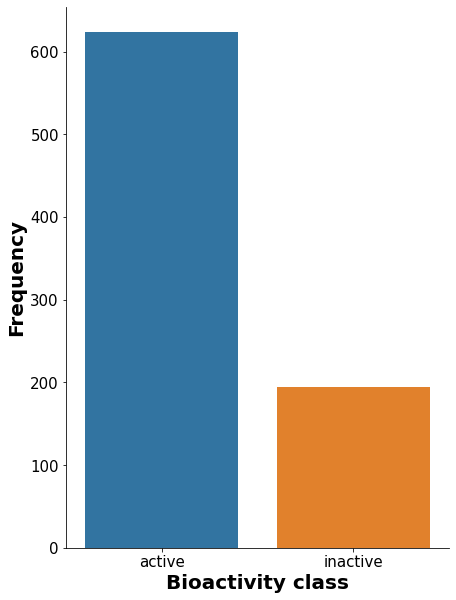

In [21]:
plt.figure(figsize=(6.5, 8.5))

sns.countplot(x='bioactivity_class', data=df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('Frequency', fontsize=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)
sns.set(style='ticks')
sns.despine(top=True)
plt.tight_layout()
plt.savefig('plot_bioactivity_class.png')

### Pairplot of the features

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

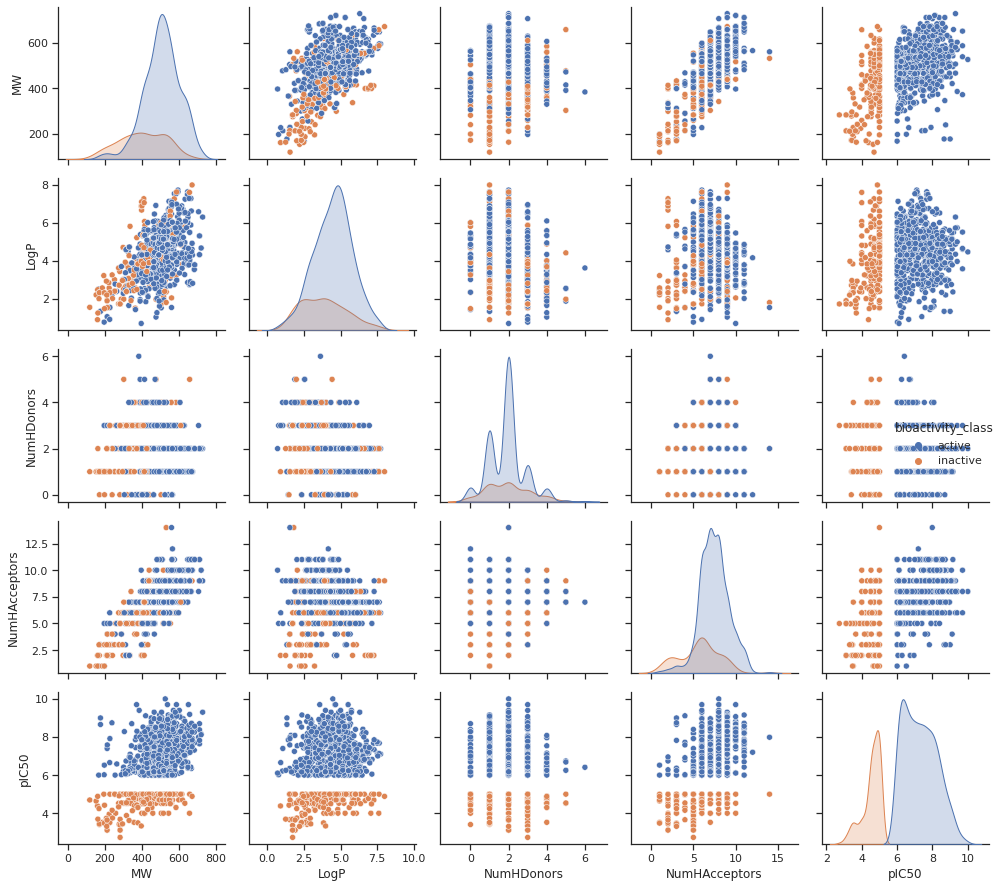

In [22]:
selection = ['bioactivity_class','MW','LogP','NumHDonors','NumHAcceptors','pIC50']
sns.pairplot(df[selection], hue='bioactivity_class')
plt.tight_layout()
plt.savefig('Pairplot.png',dpi=300)

### Boxplot of pIC50

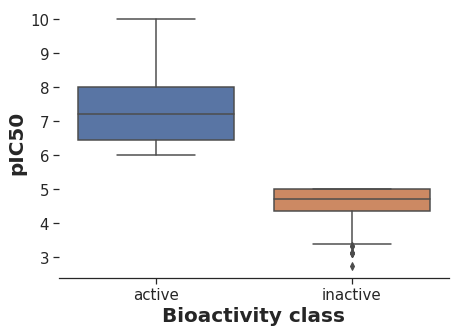

In [23]:
fig = plt.figure(figsize=(7,5))
sns.boxplot(x='bioactivity_class', y='pIC50', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('pIC50', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)
sns.despine(top=True, left=True)
plt.savefig('boxplot_pIC50.png',dpi=300);

### Boxplot of Lipinksi descriptors

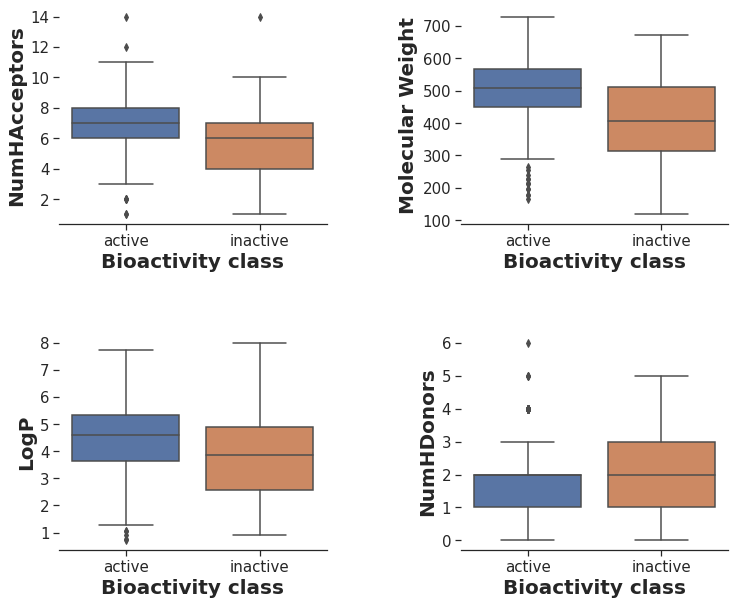

In [24]:
fig = plt.figure(figsize=(12,10))
fig.subplots_adjust(hspace=0.5,wspace=0.5)
fig.add_subplot(2,2,1)
sns.boxplot(x='bioactivity_class', y='NumHAcceptors', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('NumHAcceptors', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)

fig.add_subplot(2,2,2)
sns.boxplot(x='bioactivity_class', y='MW', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('Molecular Weight', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)

fig.add_subplot(2,2,3)
sns.boxplot(x='bioactivity_class', y='LogP', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('LogP', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)

fig.add_subplot(2,2,4)
sns.boxplot(x='bioactivity_class', y='NumHDonors', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('NumHDonors', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)

sns.despine(top=True, left=True)
plt.savefig('boxplot_lipinksi_descriptors.png',dpi=300);

In [25]:
df.to_csv('axl.csv')

## Conclusion

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.


All of the 4 Lipinski's descriptors exhibited ***statistically significant difference*** between the **actives** and **inactives**.

## importing the libraries

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from sklearn.preprocessing import LabelBinarizer
# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE
# from xgboost import XGBClassifier
# from sklearn.svm import SVC
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


%matplotlib inline

## Reading the data

## Pearson correlation and feature selection

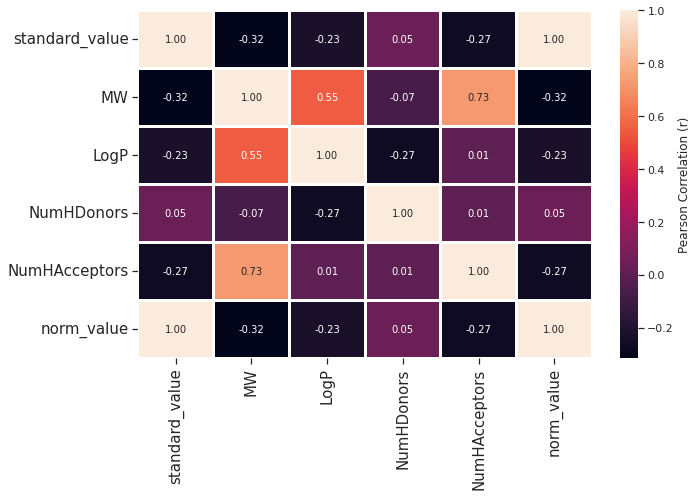

In [27]:
plt.figure(figsize=(10,7))
corr_mat = df.iloc[:,:-1].corr()
sns.heatmap(corr_mat, fmt='0.2f', annot=True, lw=2, cbar_kws={'label':'Pearson Correlation (r)'})
plt.xticks(size=15,rotation=90)
plt.yticks(size=15,rotation=0)
plt.tight_layout()
plt.savefig('Correlation.png',dpi=300);

## Preparing data for machine learning

In [28]:
# df['bioactivity_class'] = df['bioactivity_class'].map({'inactive':0, 'active':1})

## Pycaret


In [29]:
! pip install --pre pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 544 kB 7.5 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 43 kB 2.7 MB/s 
     |████████████████████████████████| 1.8 MB 72.6 MB/s 
     |████████████████████████████████| 137 kB 97.2 MB/s 
     |████████████████████████████████| 79.9 MB 1.1 MB/s 
     |████████████████████████████████| 3.3 MB 58.9 MB/s 
     |████████████████████████████████| 281 kB 94.1 MB/s 
     |████████████████████████████████| 62 kB 1.9 MB/s 
     |████████████████████████████████| 6.7 MB 56.3 MB/s 
     |████████████████████████████████| 11.2 MB 49.5 MB/s 
     |████████████████████████████████| 69 kB 7.9 MB/s 
     |████████████████████████████████| 2.0 MB 52.0 MB/s 
     |███████████████████████

In [30]:
! pip install pycaret[models]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
     |████████████████████████████████| 87 kB 8.6 MB/s 
     |████████████████████████████████| 1.3 MB 65.3 MB/s 
     |████████████████████████████████| 57 kB 6.8 MB/s 
     |████████████████████████████████| 255.9 MB 52 kB/s 
     |████████████████████████████████| 26.0 MB 50.0 MB/s 
     |████████████████████████████████| 300.3 MB 21 kB/s 
     |████████████████████████████████| 4.0 MB 70.7 MB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [31]:
# from pycaret.utils import enable_colab
# enable_colab()

In [32]:
from pycaret.classification import *

'cuml' is a soft dependency and not included in the pycaret installation. Please run: `pip install cuml` to install.
'cuml' is a soft dependency and not included in the pycaret installation. Please run: `pip install cuml` to install.
'cuml' is a soft dependency and not included in the pycaret installation. Please run: `pip install cuml` to install.
'cuml' is a soft dependency and not included in the pycaret installation. Please run: `pip install cuml` to install.


In [33]:
df.head(5)

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,norm_value,pIC50
0,CHEMBL215803,C[C@@H]1C[C@H]2CN1CCn1nc3c(cccc3c1O)-c1nc3c(cc...,1000.0,active,403.442,2.91290,2.0,8.0,1000.0,6.000000
1,CHEMBL253116,CC(CO)NC(=N)c1c(O)nsc1Nc1ccc(Nc2ccccc2)cc1,389.0,active,383.477,3.63167,6.0,7.0,389.0,6.410050
2,CHEMBL437331,CC(CO)/N=C(\N)c1c(O)nsc1Nc1ccc(Oc2ccccc2)cc1,455.0,active,384.461,3.47070,4.0,7.0,455.0,6.341989
3,CHEMBL254702,CC1CCN(c2cc(N3CCN(C)CC3)ccc2NC(=O)c2cc(C#N)c[n...,6.4,active,406.534,3.12678,2.0,5.0,6.4,8.193820
4,CHEMBL253292,CCN(CC)CCOc1ccc(Nc2cc(NC(=O)Nc3c(Cl)cccc3Cl)nc...,10000.0,inactive,489.407,5.89160,3.0,6.0,10000.0,5.000000


In [34]:
df=df.dropna(subset=['bioactivity_class'])

In [35]:
df = df.drop(['molecule_chembl_id','canonical_smiles','standard_value', 'pIC50'], axis=1)

In [36]:
df.head()

,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,norm_value
0,active,403.442,2.91290,2.0,8.0,1000.0
1,active,383.477,3.63167,6.0,7.0,389.0
2,active,384.461,3.47070,4.0,7.0,455.0
3,active,406.534,3.12678,2.0,5.0,6.4
4,inactive,489.407,5.89160,3.0,6.0,10000.0


In [37]:
clf = setup(data = df, 
             target = 'bioactivity_class',
            session_id=123)

INFO:logs:PyCaret ClassificationExperiment
INFO:logs:Logging name: clf-default-name
INFO:logs:ML Usecase: MLUsecase.CLASSIFICATION
INFO:logs:version 3.0.0.rc3
INFO:logs:Initializing setup()
INFO:logs:self.USI: e375
INFO:logs:self.variable_keys: {'X', '_is_multiclass', 'gpu_param', 'logging_param', 'y', 'X_train', 'n_jobs_param', 'data', 'pipeline', 'html_param', 'USI', '_gpu_n_jobs_param', '_ml_usecase', 'exp_id', 'seed', 'fold_generator', 'y_train', 'log_plots_param', 'idx', 'exp_name_log', 'display_container', 'y_test', 'fold_groups_param', '_all_models', 'X_test', '_all_metrics', 'memory', 'target_param', 'fix_imbalance', '_available_plots', 'fold_shuffle_param', 'master_model_container', '_all_models_internal', 'variable_keys'}
INFO:logs:Checking environment
INFO:logs:python_version: 3.7.14
INFO:logs:python_build: ('default', 'Sep  8 2022 00:06:44')
INFO:logs:machine: x86_64
INFO:logs:platform: Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic
INFO:logs:Memory: svmem(total=1361636147

,Description,Value
0,Session id,123
1,Target,bioactivity_class
2,Target type,Binary
3,Target mapping,"active: 0, inactive: 1"
4,Original data shape,"(817, 6)"
5,Transformed data shape,"(817, 6)"
6,Transformed train set shape,"(571, 6)"
7,Transformed test set shape,"(246, 6)"
8,Numeric features,5
9,Rows with missing values,0.9%


INFO:logs:Soft dependency imported: xgboost: 1.6.2
INFO:logs:Soft dependency imported: catboost: 1.0.6
INFO:logs:Soft dependency imported: xgboost: 1.6.2
INFO:logs:Soft dependency imported: catboost: 1.0.6
INFO:logs:setup() successfully completed in 1.69s...............


In [38]:
top5 = compare_models(n_select = 5)

INFO:logs:Initializing compare_models()
INFO:logs:compare_models(self=<pycaret.classification.oop.ClassificationExperiment object at 0x7ffa23145b90>, include=None, fold=None, round=4, cross_validation=True, sort=Accuracy, n_select=5, budget_time=None, turbo=True, errors=ignore, fit_kwargs=None, groups=None, experiment_custom_tags=None, probability_threshold=None, verbose=True, parallel=None, caller_params={'self': <pycaret.classification.oop.ClassificationExperiment object at 0x7ffa23145b90>, 'include': None, 'exclude': None, 'fold': None, 'round': 4, 'cross_validation': True, 'sort': 'Accuracy', 'n_select': 5, 'budget_time': None, 'turbo': True, 'errors': 'ignore', 'fit_kwargs': None, 'groups': None, 'experiment_custom_tags': None, 'probability_threshold': None, 'engines': None, 'verbose': True, 'parallel': None, '__class__': <class 'pycaret.classification.oop.ClassificationExperiment'>}, exclude=None)
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4400
knn,K Neighbors Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1350
nb,Naive Bayes,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0550
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0530
svm,SVM - Linear Kernel,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0460
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.3090
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0510
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0950
xgboost,Extreme Gradient Boosting,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.3200
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0880


Processing:   0%|          | 0/73 [00:00<?, ?it/s]

INFO:logs:Initializing Logistic Regression
INFO:logs:Total runtime is 4.6265125274658206e-05 minutes
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(self=<pycaret.classification.oop.ClassificationExperiment object at 0x7ffa23145b90>, estimator=lr, fold=StratifiedKFold(n_splits=10, random_state=None, shuffle=False), round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=False, probability_threshold=None, experiment_custom_tags=None, verbose=False, system=False, add_to_model_list=True, metrics=None, display=<pycaret.internal.display.display.CommonDisplay object at 0x7ffa010f9d10>, model_only=True, return_train_score=False, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Logistic Regression Imported successfully

INFO:logs:master_model_container: 16
INFO:logs:display_container: 2
INFO:logs:[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform'), GaussianNB(priors=None, var_smoothing=1e-09), DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       random_state=123, splitter='best'), SGDCl

In [39]:
evaluate_model(top5)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(self=<pycaret.classification.oop.ClassificationExperiment object at 0x7ffa23145b90>, estimator=[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform'), GaussianNB(priors=None, var_smoothing=1e-09), DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_f

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…